# NavTech AI/ML Engineer Assessment

### Assignment Description: Building a Resume Parser with Transformer Model

---

#### **Requirements**

1. **File Format Support**
   - Must handle the following extensions:  
     `.docx`, `.docs`, `.pdf`

2. **Transformer Model Integration**
   - Utilize a Transformer model to understand and extract structured information.
   - Possible models include **BERT**, **GPT**, or any other **transformer-based architecture** suitable for natural language understanding.

3. **Information Extraction**
   - Extract key fields such as:
     - **Contact Information:** Name, Email, Phone Number  
     - **Education History:** Institution, Degree, Graduation Year  
     - **Work Experience:** Company, Position, Description, Duration  
     - **Skills**
     - **Additional Sections:** Certifications, Projects, Awards, etc. (as applicable)

4. **Output Format**
   - Present the extracted information in **JSON format** for seamless system integration.  

#Notebook Workflow

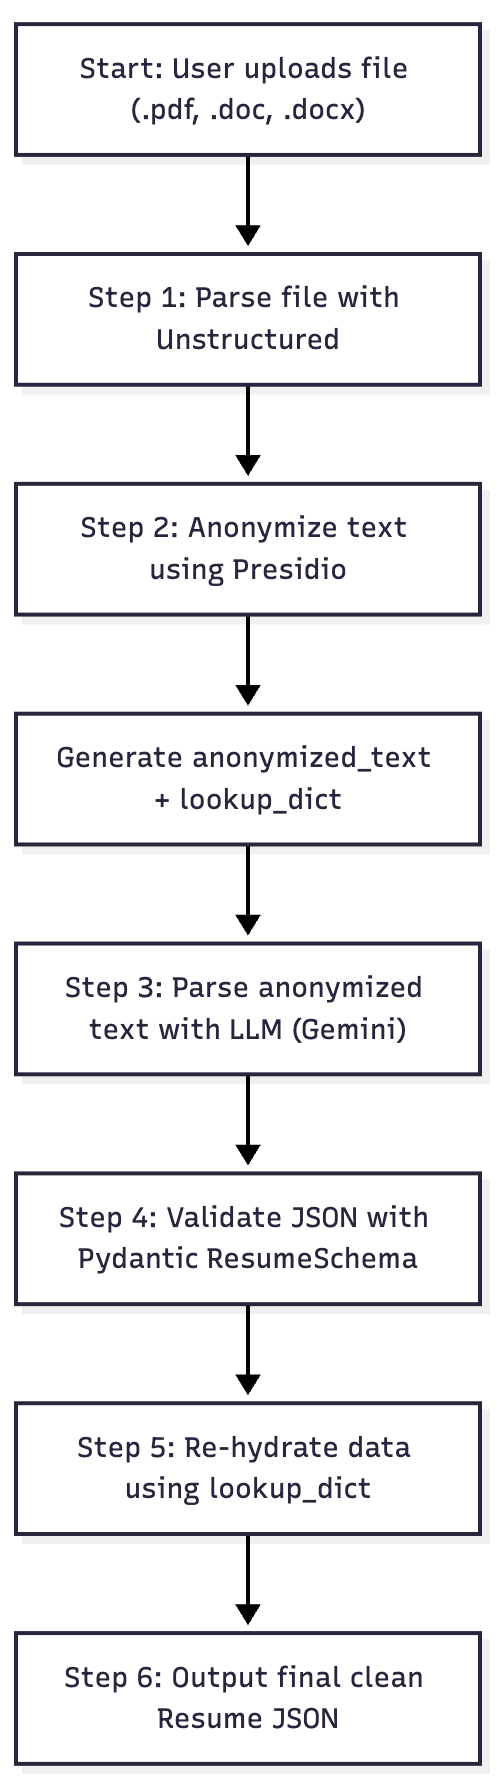

## Gemini API Key Secret Setup

1. In the Colab menu, go to:  
    **“Tools” → “Secrets” → “Add a new secret”**
2. Set the name as:  GOOGLE_API_KEY

3. Paste your API key value and click **Save**.

## Requirements Installation

In [ ]:
# Install Ubuntu System Dependencies for OCR
!sudo apt-get update
!apt-get install -y libreoffice
!sudo apt-get install -y tesseract-ocr poppler-utils

In [ ]:
# Install all required libraries
!pip install -q \
    langchain \
    langchain-google-genai \
    pydantic \
    "presidio-analyzer>=2.2.355" \
    "presidio-anonymizer>=2.2.355" \
    "spacy>=3.7.0" \
    python-docx \
    PyMuPDF \
    libmagic \
    "unstructured[all-docs]>=0.14.0" \
    "pillow-heif==0.16.0" \
    lxml \
    pydantic[email]

In [ ]:
# Install Detectron2 (the OCR model for unstructured)
!pip install -q 'git+https://github.com/facebookresearch/detectron2.git'

In [ ]:
# Download the spaCy model for Presidio
!python -m spacy download en_core_web_lg

## All Loading and Imports

In [ ]:
#All the Imports Required

import os
import json
import fitz  # PyMuPDF
import docx  # python-docx
import logging
from pathlib import Path
from collections import defaultdict
from google.colab import files, userdata
from pydantic import BaseModel, Field, EmailStr
from presidio_anonymizer import AnonymizerEngine
from unstructured.partition.auto import partition
from langchain_core.prompts import PromptTemplate
from typing import List, Optional, Dict, Any, Tuple
import unstructured_inference.models.tables as tables
from presidio_anonymizer.entities import OperatorConfig
from unstructured_inference.models.base import get_model
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.output_parsers import PydanticOutputParser
from presidio_analyzer import AnalyzerEngine, RecognizerRegistry, Pattern, PatternRecognizer


In [ ]:
# --- Pre-load unstructured.io models ---

# This prevents the need for HF_TOKEN in Google Colab

try:
    # 1. Pre-load the YOLOX layout model
    print("Loading layout model (YOLOX)...")
    _ = get_model("yolox")
    print("Layout model loaded.")

    # 2. Pre-load the Table Transformer model
    print("Loading table model (Table Transformer)...")
    tables.load_agent()
    print("Table model loaded.")

    print("\n✅ All models pre-loaded and cached successfully.")

except Exception as e:
    print("\n--- Error pre-loading models ---")
    print(f"Error: {e}")
    print("This is not critical. Models will be downloaded lazily on first use. - Lazy Loading")


## Main Code

In [ ]:
# --- Pydantic Schema Definitions For Validation---

class Contact(BaseModel):
    email: Optional[str] = Field(None, description="The person's email address")
    phone: Optional[str] = Field(None, description="The person's phone number")
    address: Optional[str] = Field(None, description="The person's physical address")
    website: Optional[str] = Field(None, description="The person's personal website or blog")
    linkedin: Optional[str] = Field(None, description="URL to the person's LinkedIn profile")
    github: Optional[str] = Field(None, description="URL to the person's GitHub profile")

class Education(BaseModel):
    institution: Optional[str] = Field(None, description="Name of the educational institution")
    degree: Optional[str] = Field(None, description="Degree obtained (e.g., B.S. in Computer Science)")
    dates: Optional[str] = Field(None, description="Graduation or attendance dates (e.g., 2018 - 2022)")
    score: Optional[str] = Field(None, description="GPA, score, or grade (e.g., 3.8/4.0)")
    location: Optional[str] = Field(None, description="Location of the institution")

class Experience(BaseModel):
    company: Optional[str] = Field(None, description="Name of the company")
    role: Optional[str] = Field(None, description="Job title or role")
    dates: Optional[str] = Field(None, description="Dates of employment (e.g., 2022 - Present)")
    duration: Optional[str] = Field(None, description="Total duration (e.g., 2 years 3 months)")
    location: Optional[str] = Field(None, description="Location of the company")
    responsibilities: List[str] = Field(default_factory=list, description="List of key responsibilities or achievements")

class Project(BaseModel):
    name: Optional[str] = Field(None, description="The name of the project")
    technologies: List[str] = Field(default_factory=list, description="List of technologies used")
    description: List[str] = Field(default_factory=list, description="List of sentences describing the project")

class Skills(BaseModel):
    languages: Optional[List[str]] = Field(default_factory=list, description="Programming languages (e.g., Python, Java)")
    frameworks: Optional[List[str]] = Field(default_factory=list, description="Frameworks (e.g., React, Django)")
    libraries: Optional[List[str]] = Field(default_factory=list, description="Libraries (e.g., Pandas, TensorFlow)")
    developer_tools: Optional[List[str]] = Field(default_factory=list, description="Developer tools (e.g., Git, Docker)")
    databases: Optional[List[str]] = Field(default_factory=list, description="Databases (e.g., PostgreSQL, MongoDB)")
    cloud_platforms: Optional[List[str]] = Field(default_factory=list, description="Cloud platforms (e.g., AWS, GCP)")
    core_concepts: Optional[List[str]] = Field(default_factory=list, description="Core CS concepts (e.g., Data Structures, Algorithms)")
    other: Optional[List[str]] = Field(default_factory=list, description="Any other relevant skills")

class Language(BaseModel):
    name: Optional[str] = Field(None, description="Spoken/human language")
    proficiency: Optional[str] = Field(None, description="Proficiency level (e.g., Native, Fluent)")

class Reference(BaseModel):
    name: Optional[str] = Field(None, description="Name of the reference")
    details: Optional[str] = Field(None, description="Contact details or relationship (e.g., 'Manager at X')")


# --- Main Resume Schema ---

class ResumeSchema(BaseModel):
    name: Optional[str] = Field(None, description="The full name of the person")
    title: Optional[str] = Field(None, description="The person's most recent job title or headline (e.g., Software Engineer)")
    contact: Contact = Field(default_factory=Contact, description="Contact information")
    summary: Optional[str] = Field(None, description="The professional summary or objective statement")
    education: List[Education] = Field(default_factory=list, description="List of educational experiences")
    experience: List[Experience] = Field(default_factory=list, description="List of professional work experiences")
    projects: List[Project] = Field(default_factory=list, description="List of personal or professional projects")
    skills: Skills = Field(default_factory=Skills, description="Categorized technical skills")
    certifications_recognitions: List[str] = Field(default_factory=list, description="List of certifications or awards")
    competitions: List[str] = Field(default_factory=list, description="List of competitions or hackathons")
    volunteering: List[str] = Field(default_factory=list, description="List of volunteering experiences")
    languages: List[Language] = Field(default_factory=list, description="Spoken/human languages and proficiency")
    references: List[Reference] = Field(default_factory=list, description="List of professional references")

print("Pydantic Schemas defined.")

In [ ]:
def get_file_text(filepath: str) -> str:
    """
    Parses .pdf, .docx, and .doc files using unstructured's
    generic partition function, applying 'hi_res' strategy
    where available.
    """
    file_path = Path(filepath)
    elements = partition(
        filename=filepath,
        strategy="hi_res",
        infer_table_structure=True,
        extract_images_in_pdf=False
    )

    text = "\n\n".join([str(el) for el in elements])
    return text

print("File parsing function defined for .pdf, .docx, and .doc")

In [ ]:

logging.getLogger("presidio-analyzer").setLevel(logging.ERROR)

# Custom Presidio Recognizers

# Phone numbers (India, US, generic 10-digit)
phone_patterns = [
    Pattern(
        name="india_phone",
        regex=r"\b(\+91[\-\s]?)?[6-9]\d{9}\b",
        score=0.8,
    ),
    Pattern(
        name="us_phone",
        regex=r"\b\(?\d{3}\)?[\s\.-]\d{3}[\s\.-]\d{4}\b",
        score=0.7,
    ),
    Pattern(
        name="generic_10_digit",
        regex=r"\b\d{10}\b",
        score=0.5,
    ),
]
phone_recognizer = PatternRecognizer(
    supported_entity="PHONE_NUMBER",
    patterns=phone_patterns,
)

# GitHub profile links
github_pattern = [
    Pattern(
        name="github_link",
        regex=r"\b(https?:\/\/)?(www\.)?github\.com\/[A-Za-z0-9_-]+\b",
        score=0.8,
    )
]
github_recognizer = PatternRecognizer(
    supported_entity="GITHUB_LINK",
    patterns=github_pattern,
)

# LinkedIn profile links
linkedin_pattern = [
    Pattern(
        name="linkedin_link",
        regex=r"\b(https?:\/\/)?(www\.)?linkedin\.com\/in\/[A-Za-z0-9_-]+\b",
        score=0.8,
    )
]
linkedin_recognizer = PatternRecognizer(
    supported_entity="LINKEDIN_LINK",
    patterns=linkedin_pattern,
)

registry = RecognizerRegistry()

#SpacyRecognizer only for PERSON
try:
    from presidio_analyzer.predefined_recognizers import SpacyRecognizer

    registry.add_recognizer(SpacyRecognizer(supported_entities=["PERSON"]))
except ImportError:
    print("Warning: SpacyRecognizer not loaded. PERSON names may be missed.")

# Email recognizer
from presidio_analyzer.predefined_recognizers import EmailRecognizer

registry.add_recognizer(EmailRecognizer())

# Custom recognizers
registry.add_recognizer(phone_recognizer)
registry.add_recognizer(github_recognizer)
registry.add_recognizer(linkedin_recognizer)

analyzer = AnalyzerEngine(registry=registry, supported_languages=["en"])
anonymizer = AnonymizerEngine()

def anonymize_and_get_lookup(text: str) -> Tuple[str, Dict[str, str]]:
    """
    Anonymize `text` and return:
      - anonymized_text: str  (with stable masks)
      - mask_to_original: { "<ENTITYTYPE_i>": "original value" }

    Example masks:
      <PERSON_0>, <EMAIL_ADDRESS_0>, <PHONE_NUMBER_0>, <GITHUB_LINK_0>, <LINKEDIN_LINK_0>, ...
    """

    analyzer_results = analyzer.analyze(text=text, language="en")

    if not analyzer_results:
        return text, {}

    mask_to_original: Dict[str, str] = {}
    counters = defaultdict(int)

    def make_mask(entity_type: str, original_value: str) -> str:
        i = counters[entity_type]
        counters[entity_type] += 1
        mask = f"<{entity_type}_{i}>"
        mask_to_original[mask] = original_value
        return mask

    entity_types = {res.entity_type for res in analyzer_results}
    operators = {}

    for et in entity_types:
        operators[et] = OperatorConfig(
            "custom",
            {
                "lambda": (lambda value, et=et: make_mask(et, value))
            },
        )

    if "DEFAULT" not in operators:
        operators["DEFAULT"] = OperatorConfig("keep", {})

    anonymized_result = anonymizer.anonymize(
        text=text,
        analyzer_results=analyzer_results,
        operators=operators,
    )

    return anonymized_result.text, mask_to_original

if __name__ == "__main__":
    print("Presidio anonymization configured.")

In [ ]:
# Lanngcahin Parsing Chain

try:
    GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
    if not GOOGLE_API_KEY:
        raise ValueError("API key not found.")
    os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
    print("Google API Key loaded successfully.")
except Exception as e:
    print("ERROR: Could not load GOOGLE_API_KEY.")
    print("Please set it in the (🔑) Secrets tab on the left.")

# Pydantic Parser
parser = PydanticOutputParser(pydantic_object=ResumeSchema)

# Model
model = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0,
    model_kwargs={"response_mime_type": "application/json"} # Enable JSON mode
)

# Prompt Template
prompt_template = PromptTemplate(
    template="""
    <system>
    You are an expert resume parsing assistant. Your task is to extract information
    from the provided resume text and format it *exactly* according to the
    JSON schema instructions below.

    The resume text has been pre-anonymized. All PII (names, emails, phones, etc.)
    have been replaced with placeholder masks like <PERSON_1> or <EMAIL_ADDRESS_1>.

    You MUST preserve these placeholder masks exactly as they appear in the text.
    For example, if the name is <PERSON_1>, the "name" field in your JSON output
    must be "<PERSON_1>". Do not try to guess the original values.

    Parse the following resume text:
    ---------------------
    {resume_text}
    ---------------------

    Now, format your entire output as a single JSON object that strictly
    adheres to the following schema.
    {format_instructions}
    </system>
    """,
    input_variables=["resume_text"],
    partial_variables={"format_instructions": parser.get_format_instructions()}
)

chain = prompt_template | model | parser

print("LangChain parsing chain defined.")

In [ ]:
def _recursive_rehydrate(data: Any, lookup_dict: dict) -> Any:
    """
    Recursively search and replace all mask occurrences in any nested structure.

    - If `data` is a string:
        replace every occurrence of any key in lookup_dict with its original value.
    - If dict/list: recurse.
    - Else: return as-is.
    """
    if isinstance(data, str):
        result = data
        for mask, original in lookup_dict.items():
            if mask in result:
                result = result.replace(mask, original)
        return result

    if isinstance(data, dict):
        return {
            key: _recursive_rehydrate(value, lookup_dict)
            for key, value in data.items()
        }

    if isinstance(data, list):
        return [_recursive_rehydrate(item, lookup_dict) for item in data]

    return data


def rehydrate_model(
    parsed_model: "ResumeSchema",
    lookup_dict: dict
) -> "ResumeSchema":
    """
    Takes the masked Pydantic model and the lookup dictionary from
    `anonymize_and_get_lookup`, and returns a new, fully re-hydrated model.
    """

    masked_dict = parsed_model.model_dump()
    rehydrated_dict = _recursive_rehydrate(masked_dict, lookup_dict)
    final_model = ResumeSchema.model_validate(rehydrated_dict)
    return final_model

print("Re-hydration function defined.")


## User Input Cell

In [ ]:
# This cell runs the entire process.
# 1. It will ask you to upload a file.
# 2. It will process it through all 6 steps.

print("Please upload your resume file (.pdf or .docx):")
uploaded = files.upload()

if not uploaded:
    print("No file uploaded. Aborting.")
else:
    filepath = list(uploaded.keys())[0]

    try:
        # --- Step 1: Parse File ---
        print(f"\n[Step 1/6] Parsing file: {filepath}...")
        raw_text = get_file_text(filepath)
        print(f"File parsed. Total characters: {len(raw_text)}")

        # --- Step 2: Anonymize ---
        print("\n[Step 2/6] Anonymizing text with Presidio...")
        anonymized_text, lookup_dict = anonymize_and_get_lookup(raw_text)
        print("Text anonymized.")
        print("--- Anonymized Text (Preview) ---")
        print(anonymized_text[:1000])
        print("\n--- PII Lookup Dictionary (Preview) ---")
        print(dict(list(lookup_dict.items())[:3]))


        # --- Step 3 & 4: Parse with Gemini & Validate with Pydantic ---
        print("\n[Step 3 & 4 /6] Calling Gemini to parse resume...")

        parsed_masked_model = chain.invoke({"resume_text": anonymized_text})

        print("Gemini call successful. Pydantic validation passed.")
        # print("\n--- Parsed Model (with masks) ---")
        # print(parsed_masked_model.model_dump_json(indent=2, exclude_none=True))


        # --- Step 5: Re-hydrate ---
        print("\n[Step 5/6] Re-hydrating data (un-masking)...")
        final_resume_model = rehydrate_model(parsed_masked_model, lookup_dict)
        print("Data re-hydrated.")


        # --- Step 6 : FINAL OUTPUT ---
        print("\n\n==========================================")
        print(" [Step 6/6] PARSING COMPLETE!")
        print("==========================================")
        print("\n--- Final, Cleaned JSON Output ---")

        # .model_dump_json() is the Pydantic way to get a clean JSON string
        final_json = final_resume_model.model_dump_json(indent=2, exclude_none=True)
        print(final_json)

    except Exception as e:
        print(f"Error: {e}")

# Alternative Approaches -
- In the process of writing this code I had tried 2 other approaches here is a google doc for reference and more details on the approaches alongwith their code

[Document](https://docs.google.com/document/d/1kmA0qL3xvemxVt6VDPqV3jbgV_ptZG6e5rmU5BueRQM/edit?usp=sharing)